# Lab 4: Basic regression - Predict fuel efficiency



## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # we use this library to load the dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load data

In [2]:
# Load the 'mpg' dataset using seaborn library into a Pandas DataFrame
df = sns.load_dataset('mpg')

MPG dataset can be viewed online at  
https://github.com/mwaskom/seaborn-data/blob/master/mpg.csv

## Data Exploration - Pandas Review

### Show the first 5 rows of the dataset

In [3]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


### Show the size of the dataframe

In [4]:
df.shape

(398, 9)

### Find the columns name and their types (numerical or categorical)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


### Find the number of missing values in each column

In [6]:
df.isnull().sum()

,0
mpg,0
cylinders,0
displacement,0
horsepower,6
weight,0
acceleration,0
model_year,0
origin,0
name,0


### Handle the missing values in the dataframe

Since the number of missing values is low, we can simply drop the rows containing them. However, as a practice and review, let's substitute the missing values in the numerical columns (if any) with the mean of the respective column and the missing values in the categorical columns (if any) with the median of the respective column.

In [7]:
# Fill missing values in numerical columns with mean
numerical_cols = df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    df[col].fillna(df[col].mean(), inplace=True)

# Fill missing values in categorical columns with mode
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

/tmp/ipython-input-1128236648.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipython-input-1128236648.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

### Compute the average and the median weight

In [8]:
print(f"Average weight: {df['weight'].mean()}")
print(f"Median weight: {df['weight'].median()}")

Average weight: 2970.424623115578
Median weight: 2803.5


### Find the number of cars that weight more than 2000 kgs

In [9]:
df[df['weight'] > 2000].shape[0]

354

### Find how many cars there are for each number of cylinders

In [10]:
df['cylinders'].value_counts()

,count
cylinders,
4,204
8,103
6,84
3,4
5,3


### Find what are the car models with number of cylinders (3 or 5)

In [11]:
df[df['cylinders'].isin([3, 5])]['name']

,name
71,mazda rx2 coupe
111,maxda rx3
243,mazda rx-4
274,audi 5000
297,mercedes benz 300d
327,audi 5000s (diesel)
334,mazda rx-7 gs


### Show the `value_counts()` of `origin` column or show the unique values of this column.

In [12]:
df['origin'].value_counts()

,count
origin,
usa,249
japan,79
europe,70


## Data Preprocessing

### Use one hot encoding to change the categorical values of `origin` column to numerical values.

- use `pd.get_dummies()` method to do the encoding
- Join the original DataFrame with the new dummy DataFrame with `pd.concat()` and use `axis=1` to concate in horizontal direction.

In [13]:
# Create dummy variables for origin column
origin_dummies = pd.get_dummies(df['origin'], prefix='origin')

# Concatenate with original dataframe
df = pd.concat([df, origin_dummies], axis=1)

### Remove the `name` and `origin` column form the dataframe to have all numerical dataframe.

In [14]:
df = df.drop(['name', 'origin'], axis=1)

### Does the input needs reshaping?

In [15]:
# No reshaping needed for this dataset as it's already in tabular format
# Each row represents one sample and each column represents one feature
print(f"Dataset shape: {df.shape}")

Dataset shape: (398, 10)


### Form features `X` and labels `y` based on the processed datafram

In [16]:
# Features are all columns except 'mpg'
X = df.drop('mpg', axis=1)
# Label is the 'mpg' column
y = df['mpg']

### Split the data into training and test sets and form `train_features`, `train_labels`, `test_features`, `test_labels`

In [17]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

### For simplicity in the following steps, convert the dataset from a pandas DataFrame to a numpy array.

In [30]:
train_features = np.array(train_features).astype(np.float32)
train_labels = np.array(train_labels).astype(np.float32)
test_features = np.array(test_features).astype(np.float32)
test_labels = np.array(test_labels).astype(np.float32)

### Do some sanity check on the shape of the data before building a model

In [19]:
print(f"Train features shape: {train_features.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train features shape: (318, 9)
Train labels shape: (318,)
Test features shape: (80, 9)
Test labels shape: (80,)


## Normalization layer

To ensure stable training of neural networks, we typically normalize the data. This process also enhances the convergence of the gradient descent algorithm.

There is not single way to normalize the data. You can also use `scikit-learn `or `pandas` to do it. However, in this lab, we will use the normalization layer provided by tensorflow which matches the other parts of the model.

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [20]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`.

It calculates the mean and variance of each feature, and store them in the layer

In [21]:
normalizer.adapt(train_features)

When the layer is called, it returns the input data, with each feature independently normalized.

In [27]:
first = train_features[0]
print('First example:', first)
print()
# Cast the 'first' array to float to ensure all elements are numerical
print('Normalized:', normalizer(first.astype(float)).numpy())

First example: [8 304.0 150.0 3433 12.0 70 False False True]

Normalized: [[ 1.5271883   1.0901965   1.2618345   0.55282634 -1.3193338  -1.6966677
  -0.46232074 -0.5117663   0.7889544 ]]


## **Approach #1:** Regression using `Linear Regression`

**You are welcome to use scikit-learn to perform linear regression on this dataset.**

However, here we aim to implement it using TensorFlow.

- As we saw in Lab Week 2, `logistic regression` is essentially a single neuron with a `sigmoid` activation function.

- Similarly, `linear regression` can be viewed as a single neuron with a `linear` activation function.

### **Step 1:** Linear regression model architecture

In [25]:
linear_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(9,)),
    normalizer,
    layers.Dense(1, activation='linear')
])

**Note:** You can define your model all at once like the cell above or you can buid the model incrementaly  (suitable for your assignment)

In [26]:
# Defining the model incrementaly (suitable for your assignment)
linear_model = tf.keras.Sequential()
linear_model.add(tf.keras.layers.Input(shape=(9,)))
linear_model.add(normalizer)
linear_model.add(layers.Dense(1, activation='linear'))

### **Step 2:** Configure the model with Keras `Model.compile()`

The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`"mean_absolute_error"`) and how (using the `tf.keras.optimizers.Adam(learning_rate=0.1)`).

**arguments:**
- optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
- loss='mean_absolute_error'

In [28]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

### **Step 3:** Train the model using the `Model.fit()` for `100` epochs, and store the output in a variable named history.

In [31]:
history = linear_model.fit(train_features, train_labels, epochs=100)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 22.9363
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.8074 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.3793 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1724 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.9397 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.1737 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.8832 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2216 
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1571 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.4466 
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.9749 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.4323 
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.4036 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.2514
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3

In [32]:
history.history

{'loss': [23.245397567749023,
  22.182294845581055,
  21.188352584838867,
  20.19483757019043,
  19.17328453063965,
  18.175588607788086,
  17.241300582885742,
  16.20628547668457,
  15.208127975463867,
  14.208133697509766,
  13.206233978271484,
  12.220760345458984,
  11.211320877075195,
  10.221797943115234,
  9.261176109313965,
  8.265389442443848,
  7.287199974060059,
  6.352722644805908,
  5.459895133972168,
  4.676548480987549,
  4.017552375793457,
  3.486468553543091,
  3.1244914531707764,
  2.909496784210205,
  2.7352025508880615,
  2.6706347465515137,
  2.6312005519866943,
  2.6082894802093506,
  2.5951180458068848,
  2.610302209854126,
  2.566837787628174,
  2.5643393993377686,
  2.58209228515625,
  2.56282901763916,
  2.580538749694824,
  2.577996253967285,
  2.5672249794006348,
  2.6154768466949463,
  2.608375072479248,
  2.562849998474121,
  2.5513904094696045,
  2.5575103759765625,
  2.5537970066070557,
  2.575115919113159,
  2.5925981998443604,
  2.5568361282348633,
  2

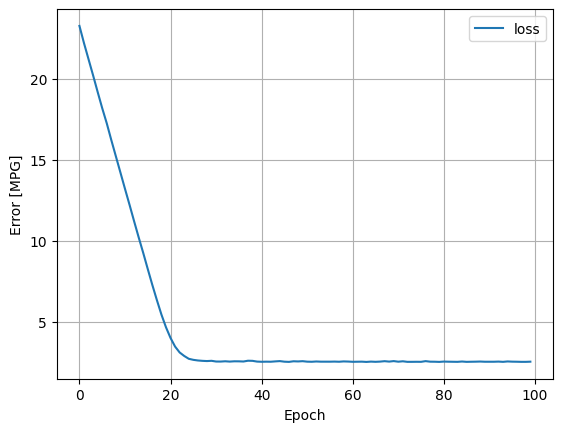

In [33]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

### Get the model summary

In [34]:
linear_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51 (212.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 19 (80.00 B)

 Optimizer params: 22 (92.00 B)

### **Step 4:** Evaluate the linear model on the test set using Keras `Model.evaluate()` and see the `mean_absolute_error` and save the result for future comparison.

In [35]:
linear_mae = linear_model.evaluate(test_features, test_labels, verbose=0)
print(f"Linear Model - Mean Absolute Error: {linear_mae}")

Linear Model - Mean Absolute Error: 2.141221523284912


## **Approach #2:** Regression using a `Deep Neural Network (DNN)`

### Solve the same problem and using deep neural network with the sample architecture;
- 1st hidden layer no. of units =  64
- 2nd hidden layer no. of units = 64
- Choose appropriate `activation` functions for hidden and output layers

In [36]:
# Build the DNN model
model_dnn = tf.keras.Sequential()
model_dnn.add(tf.keras.layers.Input(shape=(9,)))
model_dnn.add(normalizer)
model_dnn.add(layers.Dense(64, activation='relu'))
model_dnn.add(layers.Dense(64, activation='relu'))
model_dnn.add(layers.Dense(1, activation='linear'))

# Compile the model
model_dnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error'
)

# Train the model
history_dnn = model_dnn.fit(train_features, train_labels, epochs=100, verbose=0)

### Print the model summary (after training). How many parameters are there in the model?

In [37]:
model_dnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,616 (57.10 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 19 (80.00 B)

 Optimizer params: 9,732 (38.02 KB)

## Compare the evaluation result of the two approaches, i.e., linear regression and deep neural network.

In [38]:
# Evaluate DNN model
dnn_mae = model_dnn.evaluate(test_features, test_labels, verbose=0)

# Compare results
print("Model Performance Comparison:")
print(f"Linear Regression MAE: {linear_mae:.4f}")
print(f"Deep Neural Network MAE: {dnn_mae:.4f}")
print(f"\nImprovement: {((linear_mae - dnn_mae) / linear_mae * 100):.2f}%")

Model Performance Comparison:
Linear Regression MAE: 2.1412
Deep Neural Network MAE: 1.5847

Improvement: 25.99%


## Use the following large model and evaluate it on the test set.

In [39]:
model_dnn_large = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])


In [40]:
# Compile the large model
model_dnn_large.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error'
)

# Train the large model
history_large = model_dnn_large.fit(train_features, train_labels, epochs=100, verbose=0)

# Evaluate the large model
large_mae = model_dnn_large.evaluate(test_features, test_labels, verbose=0)

# Print model summary
model_dnn_large.summary()

# Compare all models
print("\nAll Models Performance Comparison:")
print(f"Linear Regression MAE: {linear_mae:.4f}")
print(f"DNN (2 layers) MAE: {dnn_mae:.4f}")
print(f"DNN Large (4 layers) MAE: {large_mae:.4f}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,576 (154.60 KB)

 Trainable params: 13,185 (51.50 KB)

 Non-trainable params: 19 (80.00 B)

 Optimizer params: 26,372 (103.02 KB)


All Models Performance Comparison:
Linear Regression MAE: 2.1412
DNN (2 layers) MAE: 1.5847
DNN Large (4 layers) MAE: 1.7134


### Explain your observation. Why do you think the large model is not performing well?

- hint: when the number of trainable parameters is very large (even larger than the number of data points), the model may overfit the training data. One way to solve this problem is to use more data.